# Experiment for k_latest_snapshot

## Setup

Firstly, the needed packages are imported,

In [1]:
import time
import os
import copy
import random

import matplotlib.pyplot as plt
import tikzplotlib

from os import path

from IPython.display import Markdown as md
from functools import reduce

from fca.api_models import Context, IncLattice


We define helper functions for readability


In [4]:
def generate_lattice(g_size, m_size, g_prime_size=None, offset=0, maximum_different_items=None):
    if g_prime_size is None:
        g_prime_size = m_size
    if maximum_different_items is None:
        maximum_different_items = m_size
    I = []
    items = set()
    iter_items = []
    for i in range(g_size):
        I.append([])
        for j in range(m_size):
            I[i].append(False)
        if len(items) < maximum_different_items:
            attrs_so_far = 0
            certain_item = []
            while attrs_so_far < g_prime_size:
                j = random.randint(0, m_size - 1)
                certain_item.append(j)
                attrs_so_far += 1
            certain_item = frozenset(certain_item)
            if certain_item not in items:
                items.add(certain_item)
                iter_items.append(certain_item)
        random_item = random.choice(iter_items)
        for j in random_item:
            I[i][j] = True
    
    for l in I:
        if not any(l):
            l[random.randrange(m_size)] = True
    
    for j in range(m_size):
        column = [I[i][j] for i in range(g_size)]
        if not any(column):
            I[random.randrange(g_size)][j] = True

    O = ['o' + str(offset + i) for i in range(g_size)]
    A = ['a' + str(i) for i in range(m_size)]
    return IncLattice(Context(O, A, I))

def lattices_report(l1, l2, lm, l1_name='L_1', l2_name='L_2', lm_name='L_m'):
    return md(lattice_report(l1, l1_name) + "\n" + lattice_report(l2, l2_name) + "\n" + lattice_report(lm, lm_name))

def lattice_report(l, name="L"):
    max_g_prime = reduce(lambda x, y: x if x > y else y,
                         (reduce(lambda x, y: x + (1 if y else 0), values, 0) for values in l.ctx.I),
                         0)

    return f"$|{name}| = {len(l.concepts)}$, $|G| = {len(l.ctx.G)}$, $|M| = {len(l.ctx.M)}$, " \
           f"$max(|g'|) = {max_g_prime}$"

# Time Experiment

First, we create a wrapper to measure the elapsed time for functions

In [5]:
def measure_time(f):
    def wrap(*args, **kwargs):
        ts = time.time()
        res = f(*args, **kwargs)
        tf = time.time()
        elapsed_time = tf - ts
        print(f'{f.__name__} execution_time: {elapsed_time*1000}ms')
        return res
    return wrap

## Add the rows of L1 to L2 vs Merge

Then, a function to merge both snapshots.

In [6]:
def merge_by_incrementally_adding_rows(l1, l2):
    fst_ctx = l1.ctx
    snd_ctx = l2.ctx
    if len(fst_ctx.O) < len(snd_ctx.O):
        fst_ctx, snd_ctx = snd_ctx, fst_ctx
        l1, l2 = l2, l1
    
    copy_l = IncLattice.copy(l1)  # O(|L|)
    # since they might have a different set of attributes
    add_attributes(copy_l, l2)
    attr_idx = get_attribute_ids(copy_l.ctx)
    for i, g in enumerate(snd_ctx.O):
        attrs = get_attributes(i, snd_ctx, attr_idx)
        copy_l.add_intent(g, attrs)
    
    return copy_l

def add_attributes(l1, l2):
    attributes_1 = set(l1.ctx.A)
    attributes_2 = set(l2.ctx.A)
    new_attributes = attributes_2.difference(attributes_1)
    for a in new_attributes:
        l1.add_attribute(a)

def get_attributes(i: int, ctx: Context, ids: dict):
    attrs = []
    for j, m in enumerate(ctx.A):
        if ctx.I[i][j]:
            attrs.append(ids[m])
    return attrs

def get_attribute_ids(ctx: Context):
    attr_idx = dict()
    for j, m in enumerate(ctx.A):
        attr_idx[m] = j
    return attr_idx

Define the function to do the merge

In [7]:
def merge_by_using_both_calculated_lattices(l1, l2):
    return l1.merge_concepts(l2)

Start the experiments

### Let us consider the rate 1:0.5

In [49]:
lattice_1 = generate_lattice(g_size=100, m_size=50, g_prime_size=10, maximum_different_items=10)
lattice_2 = generate_lattice(g_size=50, m_size=50, g_prime_size=10, offset=100, maximum_different_items=10)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 26.5 ms
CPU times: user 9.37 ms, sys: 0 ns, total: 9.37 ms
Wall time: 9.34 ms


$|L_1| = 62$, $|G| = 100$, $|M| = 50$, $max(|g'|) = 11$
$|L_2| = 47$, $|G| = 50$, $|M| = 50$, $max(|g'|) = 11$
$|L_m| = 183$, $|G| = 150$, $|M| = 50$, $max(|g'|) = 11$

In [50]:
lattice_1 = generate_lattice(g_size=250, m_size=50, g_prime_size=10, maximum_different_items=20)
lattice_2 = generate_lattice(g_size=125, m_size=50, g_prime_size=10, offset=500, maximum_different_items=20)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 176 ms
CPU times: user 58.8 ms, sys: 0 ns, total: 58.8 ms
Wall time: 58.8 ms


$|L_1| = 150$, $|G| = 250$, $|M| = 50$, $max(|g'|) = 11$
$|L_2| = 150$, $|G| = 125$, $|M| = 50$, $max(|g'|) = 11$
$|L_m| = 472$, $|G| = 375$, $|M| = 50$, $max(|g'|) = 11$

In [51]:
lattice_1 = generate_lattice(g_size=500, m_size=50, g_prime_size=10, maximum_different_items=25)
lattice_2 = generate_lattice(g_size=250, m_size=50, g_prime_size=10, offset=500, maximum_different_items=25)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 697 ms, sys: 4 µs, total: 697 ms
Wall time: 697 ms
CPU times: user 206 ms, sys: 3 µs, total: 206 ms
Wall time: 205 ms


$|L_1| = 235$, $|G| = 500$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 219$, $|G| = 250$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 693$, $|G| = 750$, $|M| = 50$, $max(|g'|) = 10$

In [52]:
lattice_1 = generate_lattice(g_size=1000, m_size=50, g_prime_size=10, maximum_different_items=30)
lattice_2 = generate_lattice(g_size=500, m_size=50, g_prime_size=10, offset=1000, maximum_different_items=30)


%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 2.74 s, sys: 8 ms, total: 2.75 s
Wall time: 2.75 s
CPU times: user 839 ms, sys: 7.99 ms, total: 847 ms
Wall time: 842 ms


$|L_1| = 279$, $|G| = 1000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 290$, $|G| = 500$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 874$, $|G| = 1500$, $|M| = 50$, $max(|g'|) = 10$

In [54]:
lattice_1 = generate_lattice(g_size=2000, m_size=50, g_prime_size=10, maximum_different_items=40)
lattice_2 = generate_lattice(g_size=1000, m_size=50, g_prime_size=10, offset=2000, maximum_different_items=40)


%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 19.6 s, sys: 24 ms, total: 19.6 s
Wall time: 19.6 s
CPU times: user 4.06 s, sys: 12 ms, total: 4.08 s
Wall time: 4.04 s


$|L_1| = 456$, $|G| = 2000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 454$, $|G| = 1000$, $|M| = 50$, $max(|g'|) = 11$
$|L_m| = 1309$, $|G| = 3000$, $|M| = 50$, $max(|g'|) = 11$

In [55]:
lattice_1 = generate_lattice(g_size=4000, m_size=50, g_prime_size=10, maximum_different_items=42)
lattice_2 = generate_lattice(g_size=2000, m_size=50, g_prime_size=10, offset=4000, maximum_different_items=42)


%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 1min 19s, sys: 28 ms, total: 1min 19s
Wall time: 1min 19s
CPU times: user 15.2 s, sys: 88.1 ms, total: 15.3 s
Wall time: 15.2 s


$|L_1| = 500$, $|G| = 4000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 505$, $|G| = 2000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 1459$, $|G| = 6000$, $|M| = 50$, $max(|g'|) = 10$

In [56]:
lattice_1 = generate_lattice(g_size=8000, m_size=50, g_prime_size=10, maximum_different_items=45)
lattice_2 = generate_lattice(g_size=4000, m_size=50, g_prime_size=10, offset=8000, maximum_different_items=45)


%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 7min 13s, sys: 288 ms, total: 7min 14s
Wall time: 7min 13s
CPU times: user 1min 1s, sys: 341 ms, total: 1min 1s
Wall time: 1min


$|L_1| = 562$, $|G| = 8000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 517$, $|G| = 4000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 1544$, $|G| = 12000$, $|M| = 50$, $max(|g'|) = 10$

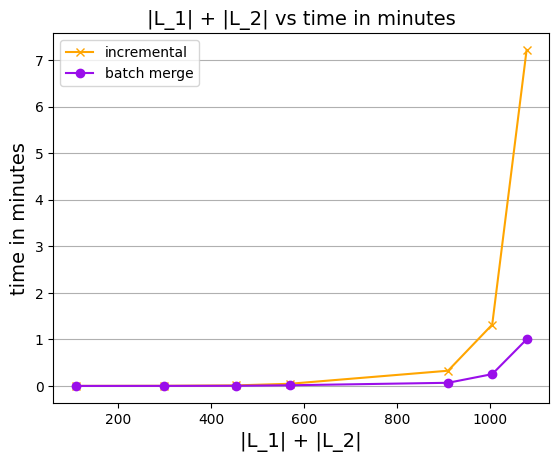

In [72]:
l_plus_ls_size = [62 + 47, 150 + 150, 235 + 219, 279 + 290, 456 + 454, 500 + 505, 562 + 517]
time_passed = [x/60 for x in [.026, .176, .697, 2.75, 19.6, 1 * 60 + 19, 7 * 60 + 13]]
time_passed_for_merge = [x/60 for x in [.009, .058, .205, .842, 4.04, 15.2, 60]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|L_1| + |L_2| vs time in minutes', fontsize=14)
plt.xlabel('|L_1| + |L_2|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_minutes.tex")
plt.show()

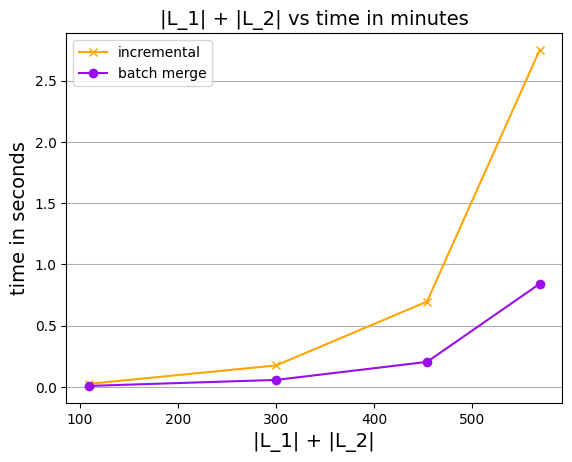

In [74]:
l_plus_ls_size = [62 + 47, 150 + 150, 235 + 219, 279 + 290]
time_passed = [x for x in [.026, .176, .697, 2.75]]
time_passed_for_merge = [x for x in [.009, .058, .205, .842]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|L_1| + |L_2| vs time in minutes', fontsize=14)
plt.xlabel('|L_1| + |L_2|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_seconds.tex")
plt.show()

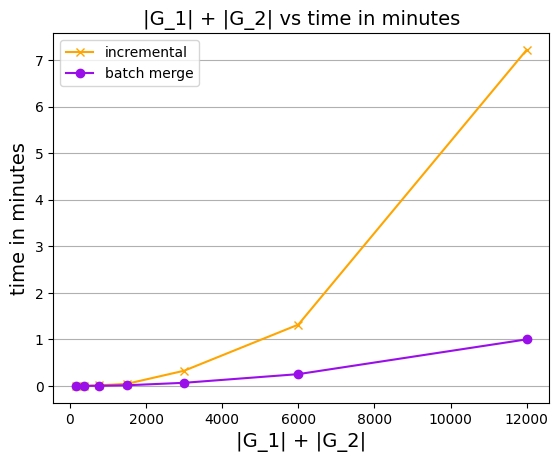

In [6]:
l_plus_ls_size = [100 + 50, 250 + 125, 500 + 250, 1000 + 500, 2000 + 1000, 4000 + 2000, 8000 + 4000]
time_passed = [x/60 for x in [.026, .176, .697, 2.75, 19.6, 1 * 60 + 19, 7 * 60 + 13]]
time_passed_for_merge = [x/60 for x in [.009, .058, .205, .842, 4.04, 15.2, 60]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|G_1| + |G_2| vs time in minutes', fontsize=14)
plt.xlabel('|G_1| + |G_2|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_g_sizes_vs_minutes.tex")
plt.show()

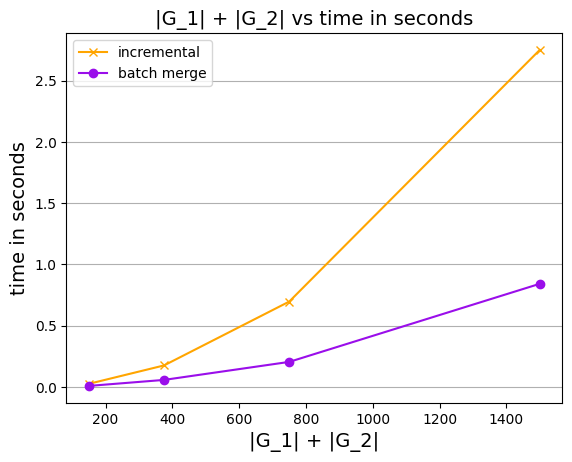

In [5]:
l_plus_ls_size = [100 + 50, 250 + 125, 500 + 250, 1000 + 500]
time_passed = [x for x in [.026, .176, .697, 2.75]]
time_passed_for_merge = [x for x in [.009, .058, .205, .842]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|G_1| + |G_2| vs time in seconds', fontsize=14)
plt.xlabel('|G_1| + |G_2|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_g_sizes_vs_seconds.tex")
plt.show()

### Let us consider the rate 1:1

In [57]:
lattice_1 = generate_lattice(g_size=100, m_size=50, g_prime_size=10, maximum_different_items=10)
lattice_2 = generate_lattice(g_size=100, m_size=50, g_prime_size=10, offset=100, maximum_different_items=10)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 108 ms, sys: 5 µs, total: 108 ms
Wall time: 107 ms
CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 20.2 ms


$|L_1| = 63$, $|G| = 100$, $|M| = 50$, $max(|g'|) = 12$
$|L_2| = 64$, $|G| = 100$, $|M| = 50$, $max(|g'|) = 11$
$|L_m| = 208$, $|G| = 200$, $|M| = 50$, $max(|g'|) = 12$

In [58]:
lattice_1 = generate_lattice(g_size=250, m_size=50, g_prime_size=10, maximum_different_items=20)
lattice_2 = generate_lattice(g_size=250, m_size=50, g_prime_size=10, offset=250, maximum_different_items=20)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 664 ms, sys: 0 ns, total: 664 ms
Wall time: 664 ms
CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms


$|L_1| = 157$, $|G| = 250$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 167$, $|G| = 250$, $|M| = 50$, $max(|g'|) = 11$
$|L_m| = 508$, $|G| = 500$, $|M| = 50$, $max(|g'|) = 11$

In [59]:
lattice_1 = generate_lattice(g_size=500, m_size=50, g_prime_size=10, maximum_different_items=25)
lattice_2 = generate_lattice(g_size=500, m_size=50, g_prime_size=10, offset=500, maximum_different_items=25)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 2.67 s, sys: 4 ms, total: 2.68 s
Wall time: 2.68 s
CPU times: user 520 ms, sys: 7.99 ms, total: 528 ms
Wall time: 523 ms


$|L_1| = 225$, $|G| = 500$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 223$, $|G| = 500$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 659$, $|G| = 1000$, $|M| = 50$, $max(|g'|) = 10$

In [60]:
lattice_1 = generate_lattice(g_size=1000, m_size=50, g_prime_size=10, maximum_different_items=30)
lattice_2 = generate_lattice(g_size=1000, m_size=50, g_prime_size=10, offset=1000, maximum_different_items=30)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 19.1 s, sys: 7.99 ms, total: 19.1 s
Wall time: 19.1 s
CPU times: user 2.51 s, sys: 4.03 ms, total: 2.51 s
Wall time: 2.49 s


$|L_1| = 274$, $|G| = 1000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 323$, $|G| = 1000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 900$, $|G| = 2000$, $|M| = 50$, $max(|g'|) = 10$

In [61]:
lattice_1 = generate_lattice(g_size=2000, m_size=50, g_prime_size=10, maximum_different_items=40)
lattice_2 = generate_lattice(g_size=2000, m_size=50, g_prime_size=10, offset=2000, maximum_different_items=40)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 1min 20s, sys: 35.9 ms, total: 1min 20s
Wall time: 1min 20s
CPU times: user 11.3 s, sys: 80.1 ms, total: 11.4 s
Wall time: 11.3 s


$|L_1| = 463$, $|G| = 2000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 478$, $|G| = 2000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 1421$, $|G| = 4000$, $|M| = 50$, $max(|g'|) = 10$

In [62]:
lattice_1 = generate_lattice(g_size=4000, m_size=50, g_prime_size=10, maximum_different_items=42)
lattice_2 = generate_lattice(g_size=4000, m_size=50, g_prime_size=10, offset=4000, maximum_different_items=42)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 7min 23s, sys: 340 ms, total: 7min 24s
Wall time: 7min 24s
CPU times: user 45.6 s, sys: 212 ms, total: 45.8 s
Wall time: 45.4 s


$|L_1| = 484$, $|G| = 4000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 537$, $|G| = 4000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 1420$, $|G| = 8000$, $|M| = 50$, $max(|g'|) = 10$

In [69]:
lattice_1 = generate_lattice(g_size=8000, m_size=50, g_prime_size=10, maximum_different_items=45)
lattice_2 = generate_lattice(g_size=8000, m_size=50, g_prime_size=10, offset=8000, maximum_different_items=45)

%time l1 = merge_by_incrementally_adding_rows(lattice_1, lattice_2)
%time l2 = merge_by_using_both_calculated_lattices(lattice_1, lattice_2)
assert len(l1.concepts) == len(l2)
lattices_report(lattice_1, lattice_2, l1)

CPU times: user 41min 36s, sys: 2.27 s, total: 41min 38s
Wall time: 41min 36s
CPU times: user 2min 51s, sys: 829 ms, total: 2min 52s
Wall time: 2min 50s


$|L_1| = 512$, $|G| = 8000$, $|M| = 50$, $max(|g'|) = 10$
$|L_2| = 539$, $|G| = 8000$, $|M| = 50$, $max(|g'|) = 10$
$|L_m| = 1545$, $|G| = 16000$, $|M| = 50$, $max(|g'|) = 10$

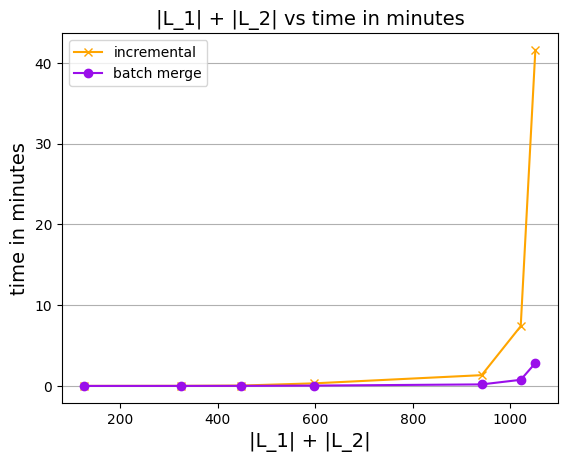

In [76]:
l_plus_ls_size = [63 + 64, 157 + 167, 225 + 223, 274 + 323, 463 + 478, 484 + 537, 512 + 539]
time_passed = [x/60 for x in [.107, .664, 2.68, 19.1, 1 * 60 + 20, 7 * 60 + 24, 41 * 60 + 36]]
time_passed_for_merge = [x/60 for x in [.020, .147, .523, 2.49, 11.3, 45.4, 2 * 60 + 50]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|L_1| + |L_2| vs time in minutes', fontsize=14)
plt.xlabel('|L_1| + |L_2|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_minutes_ratio_1_1.tex")
plt.show()

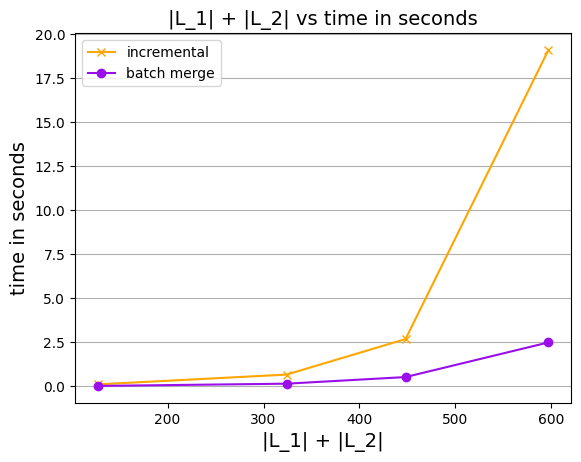

In [5]:
l_plus_ls_size = [63 + 64, 157 + 167, 225 + 223, 274 + 323]
time_passed = [x for x in [.107, .664, 2.68, 19.1]]
time_passed_for_merge = [x for x in [.020, .147, .523, 2.49]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|L_1| + |L_2| vs time in seconds', fontsize=14)
plt.xlabel('|L_1| + |L_2|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_seconds_ratio_1_1.tex")
plt.show()

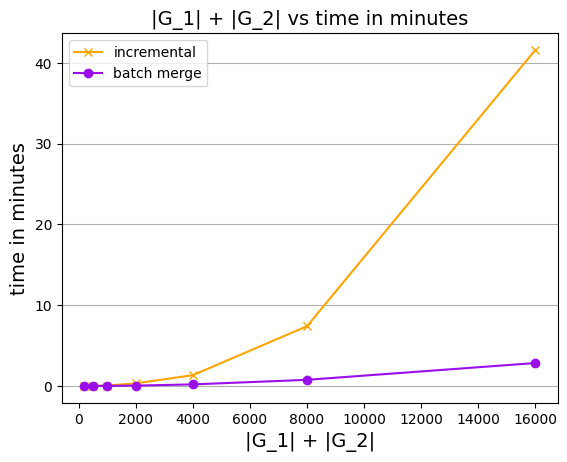

In [6]:
l_plus_ls_size = [100 + 100, 250 + 250, 500 + 500, 1000 + 1000, 2000 + 2000, 4000 + 4000, 8000 + 8000]
time_passed = [x/60 for x in [.107, .664, 2.68, 19.1, 1 * 60 + 20, 7 * 60 + 24, 41 * 60 + 36]]
time_passed_for_merge = [x/60 for x in [.020, .147, .523, 2.49, 11.3, 45.4, 2 * 60 + 50]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|G_1| + |G_2| vs time in minutes', fontsize=14)
plt.xlabel('|G_1| + |G_2|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_g_sizes_vs_minutes_ratio_1_1.tex")
plt.show()

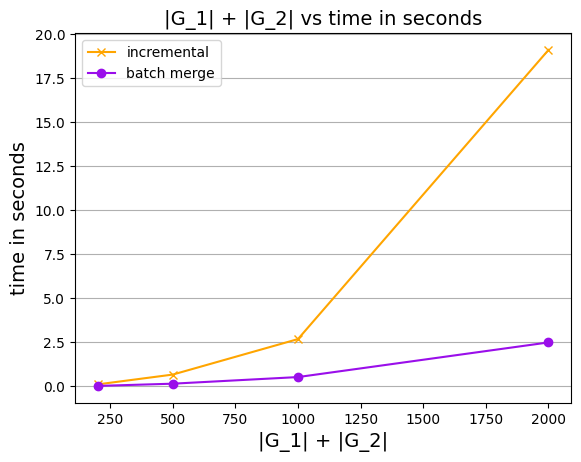

In [4]:
l_plus_ls_size = [100 + 100, 250 + 250, 500 + 500, 1000 + 1000]
time_passed = [x for x in [.107, .664, 2.68, 19.1]]
time_passed_for_merge = [x for x in [.020, .147, .523, 2.49]]
  
plt.plot(l_plus_ls_size, time_passed, color='orange', marker='x', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='#9a0eea', marker='o', label="batch merge")
plt.title('|G_1| + |G_2| vs time in seconds', fontsize=14)
plt.xlabel('|G_1| + |G_2|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_g_sizes_vs_seconds_ratio_1_1.tex")
plt.show()